In [1]:
import torch
from torch import nn
import torch.nn.functional as F

In [2]:
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [26]:
from bootcamp_libs.device import find_device

device = torch.device(find_device())
device

device(type='cpu')

In [4]:
from torchvision import datasets

trainset = datasets.MNIST(
    root="./data", train=True, download=True, transform=None)

print('Scaled Mean Pixel Value {} \nScaled Pixel Values Std: {}'.format(
    trainset.data.float().mean() / 255, trainset.data.float().std() / 255))

100%|██████████| 9912422/9912422 [01:15<00:00, 130937.23it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 765809.17it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:05<00:00, 303353.81it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5964473.63it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Scaled Mean Pixel Value 0.13066047430038452 
Scaled Pixel Values Std: 0.30810779333114624


In [5]:
from torchvision import transforms

mean = 0.13066048920154572
std = 0.30810779333114624

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean=(mean,), std=(std,))])

train_mnist = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform)

print("train size: ", len(train_mnist))

train size:  60000


In [6]:
from torch.utils.data import DataLoader

batch_size = 64

train_dl = DataLoader(train_mnist,
                                 shuffle=True,
                                 batch_size=batch_size)
                                 
print("number of batch per epoch: ", len(train_dl))

number of batch per epoch:  938


In [7]:
import matplotlib.pyplot as plt


def plot_loss(loss, title=None, figsize=(10, 5)):

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(loss)
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('epoch')
    ax.grid()

In [12]:
from torch.nn.parameter import Parameter

w = Parameter(torch.empty(2, 4))
nn.init.kaiming_normal_(w)
w

Parameter containing:
tensor([[ 0.5696,  0.5064, -0.3280,  0.6740],
        [-0.9811,  0.5318,  0.9918,  0.1191]], requires_grad=True)

In [15]:
import torch.nn.functional as F

class MyLinear(nn.Module):

    def __init__(self, in_f, out_f, bias=True, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.bias = bias
        self.w = Parameter(torch.empty(out_f, in_f))
        if bias:
            self.b = Parameter(torch.empty(out_f)) 
        self.reset_params()   ### initialization paramters
    
    def reset_params(self):
        nn.init.kaiming_normal_(self.w, nonlinearity="relu")
        if self.bias:
            nn.init.constant_(self.b, 0)

    def forward(self, x):
        F.linear(x, self.w, self.b)



In [23]:
model = nn.Sequential(MyLinear(20, 40), MyLinear(40, 2))

nn.init._calculate_fan_in_and_fan_out(dict(model.named_parameters())["0.w"])

(20, 40)

In [24]:
from bootcamp_libs.model_operation import per_epoch


class NN(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hid_dim) ### input
        self.layer2 = nn.Linear(hid_dim, hid_dim)  ### hidden layer
        self.layer3 = nn.Linear(hid_dim, output_dim) ### output
        self.init_params()

    def init_params(self):
        for n, p in self.named_parameters():
            if 'weight' in n:
                nn.init.kaiming_normal_(p, nonlinearity='relu')
            elif 'bias' in n:
                nn.init.constant_(p, 0)

    def forward(self, x):
        x = x.view(x.size(0), -1)   ### flatten
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x


    def fit(self, train_dl, optimizer, criterion, device="cpu", n_epochs=5):
        losses = []

        self.init_params()

        for epoch in range(n_epochs):
            epoch_losses = per_epoch(
                train_dl, self, optimizer, criterion, device)
            losses.extend(epoch_losses)

        return losses

In [25]:
input_dim = 784
hid_dim = 256
output_dim = 10

model = NN(input_dim, hid_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss().to(device)

In [27]:
class SGD:
    def __init__(self, model_params, lr=1e-3):
        self.model_params = list(model_params)
        self.lr = lr
        
    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param in self.model_params:
            param.sub_(self.lr * param.grad)

In [28]:
optimizer = SGD(model.parameters())
sgd_loss = model.fit(train_dl, optimizer, criterion, device)

938it [01:51,  8.42it/s]
938it [01:36,  9.68it/s]
938it [01:04, 14.47it/s]
938it [00:36, 25.56it/s]
938it [00:37, 25.31it/s]


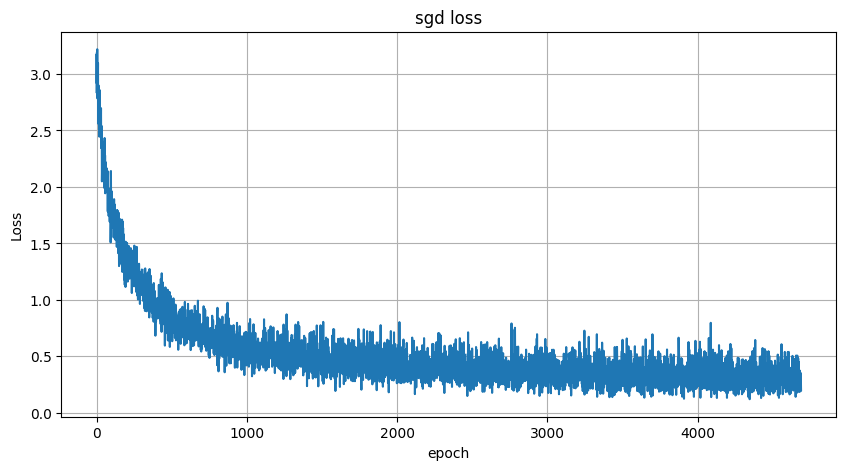

In [12]:
plot_loss(sgd_loss, "sgd loss")

In [29]:
class Momentum:
    def __init__(self, model_params, lr=1e-3, momentum=0.9):
        self.model_params = list(model_params)
        self.lr = lr
        self.momentum = momentum
        self.m = [torch.zeros_like(p) for p in self.model_params]

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, m in zip(self.model_params, self.m):
            m.mul_(self.momentum).sub_(self.lr * param.grad)
            param.add_(m)

In [30]:
optimizer = Momentum(model.parameters())
momentum_loss = model.fit(train_dl, optimizer, criterion, device)

0it [00:00, ?it/s]

938it [01:14, 12.54it/s]
938it [00:32, 29.17it/s]
938it [00:30, 30.88it/s]
938it [00:28, 32.74it/s]
938it [00:44, 20.86it/s]


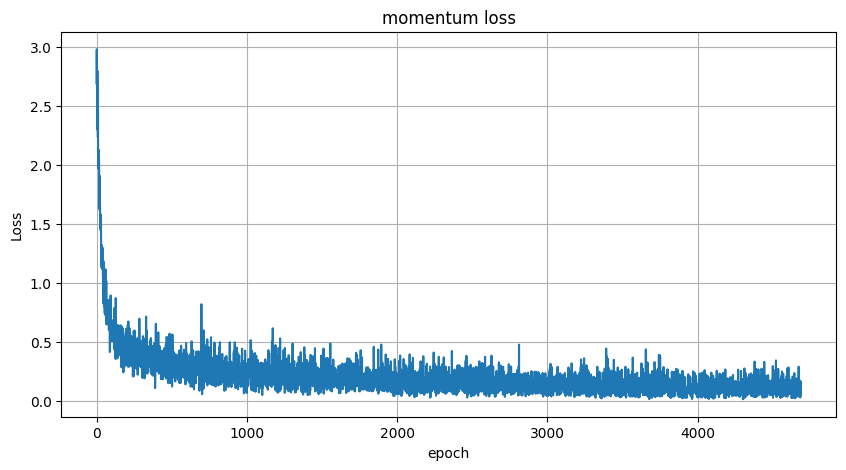

In [15]:
plot_loss(momentum_loss, "momentum loss")

In [16]:
def plot_losses(losses, labels, title=None, figsize=(10, 5)):

    fig, ax = plt.subplots(figsize=figsize)
    for loss, label in zip(losses, labels):
        ax.plot(loss, label=label)
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Update Steps')
    ax.grid()
    ax.legend(loc='upper right')

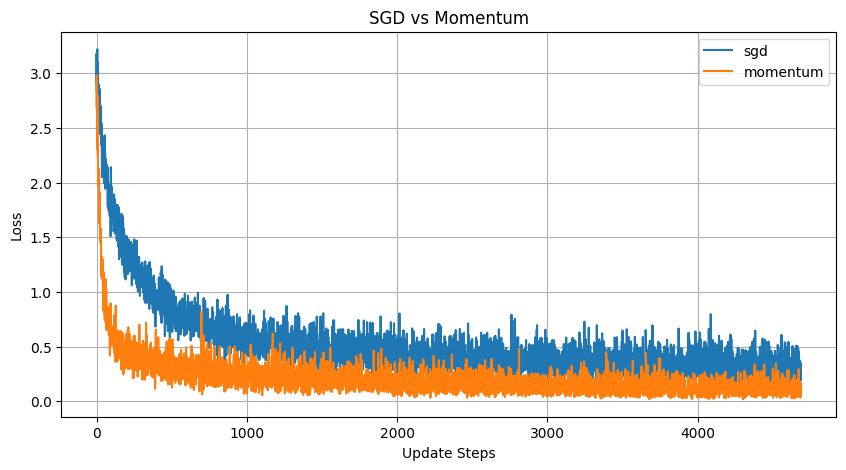

In [18]:
losses = [sgd_loss, momentum_loss]
labels = ['sgd', 'momentum']

plot_losses(losses, labels, 'SGD vs Momentum')